In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
import matplotlib
%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.__version__

'1.13.1'

In [3]:
import sys

In [6]:
sys.path.append('../odcd/cd/')

In [7]:
import model_symmetries as vsf

In [8]:
from scipy.stats import entropy

# Data prep

In [9]:
df_white = pd.read_csv('/home/fdz/git/concept_drift_exps/data/wine/winequality_white.csv')

In [10]:
df_white.shape

(4898, 12)

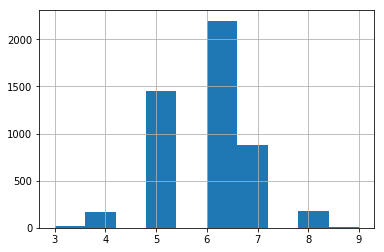

In [11]:
df_white['quality'].hist(bins=10)

In [12]:
df_white['quality'].value_counts() / len(df_white)

6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64

In [13]:
binary_target = True
if binary_target:
    df_white['target'] = df_white['quality'].apply(lambda x: 0 if x < 6 else 1)
else:
    df_white['target'] = df_white['quality']
df_white.drop('quality', axis=1, inplace=True)
target = 'target'
df_white[target].value_counts() / len(df_white)

1    0.665169
0    0.334831
Name: target, dtype: float64

In [14]:
features = [col for col in df_white.columns if col != target]

In [15]:
X, y = df_white[features].values, df_white[target].values

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scale = True
if scale:
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

In [20]:
y_test.shape

(1225,)

# Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
lg = LogisticRegression()
lg.fit(X_train, y_train)

/home/fdz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [24]:
y_preds_train = lg.predict(X_train)
y_preds_test = lg.predict(X_test)

In [25]:
accuracy_score(y_preds_train, y_train)

0.74380615300844

In [26]:
confusion_matrix(y_preds_train, y_train)

array([[ 591,  301],
       [ 640, 2141]])

In [27]:
accuracy_score(y_preds_test, y_test)

0.726530612244898

In [28]:
confusion_matrix(y_preds_test, y_test)

array([[185, 111],
       [224, 705]])

# Gxb

In [29]:
from xgboost import XGBClassifier

In [30]:
xgb = XGBClassifier(max_depth=10, n_estimators=100)

In [31]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [32]:
y_preds_train = xgb.predict(X_train)
y_preds_test = xgb.predict(X_test)

In [33]:
accuracy_score(y_preds_train, y_train)

0.9991832289681459

In [34]:
confusion_matrix(y_preds_train, y_train)

array([[1228,    0],
       [   3, 2442]])

In [35]:
accuracy_score(y_preds_test, y_test)

0.8326530612244898

In [36]:
confusion_matrix(y_preds_test, y_test)

array([[296,  92],
       [113, 724]])

# NN

In [37]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [38]:
y_train = np.delete(y_train, np.where(~y_train.any(axis=0)), axis=1)
y_test = np.delete(y_test, np.where(~y_test.any(axis=0)), axis=1)

In [39]:
def model():
    
    x_in = tf.keras.layers.Input(shape=(11, ))
    x = tf.keras.layers.Dense(100, activation='relu')(x_in)
    #x = tf.keras.layers.Dense(50, activation='relu')(x_in)
    if binary_target:
        out = tf.keras.layers.Dense(2, activation='softmax')(x)
    else:
        out = tf.keras.layers.Dense(7, activation='softmax')(x)
    clf = tf.keras.models.Model(x_in, out)
    clf.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    clf.summary()
    return clf

In [40]:
clf = model()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 1,402
Trainable params: 1,402
Non-trainable params: 0
_________________________________________________________________


In [41]:
np.where(~y_test.any(axis=0))

(array([], dtype=int64),)

In [42]:
print(y_train.shape, y_test.shape)

(3673, 2) (1225, 2)


In [43]:
clf.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 3673 samples, validate on 1225 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3673/3673 [==============================] - 0s 55us/sample - loss: 0.5987 - acc: 0.6681 - val_loss: 0.5707 - val_acc: 0.6751
Epoch 2/100
3673/3673 [==============================] - 0s 25us/sample - loss: 0.5435 - acc: 0.7103 - val_loss: 0.5464 - val_acc: 0.7078
Epoch 3/100
3673/3673 [==============================] - 0s 25us/sample - loss: 0.5215 - acc: 0.7302 - val_loss: 0.5337 - val_acc: 0.7298
Epoch 4/100
3673/3673 [==============================] - 0s 27us/sample - loss: 0.5115 - acc: 0.7411 - val_loss: 0.5325 - val_acc: 0.7224
Epoch 5/100
3673/3673 [==============================] - 0s 25us/sample - loss: 0.5057 - acc: 0.7433 - val_loss: 0.5251 - val_acc: 0.7388
Epoch 6/100
3673/3673 [==============================] - 0s 27us/sample - loss: 0.5038 - acc: 0.7438 - val_loss: 0.5230 - val_acc: 0.7339
Epoch 7/100
3673/3673 [==============================] - 0s 26us/sample - lo

Epoch 58/100
3673/3673 [==============================] - 0s 26us/sample - loss: 0.4658 - acc: 0.7759 - val_loss: 0.4870 - val_acc: 0.7722
Epoch 59/100
3673/3673 [==============================] - 0s 27us/sample - loss: 0.4660 - acc: 0.7759 - val_loss: 0.4899 - val_acc: 0.7649
Epoch 60/100
3673/3673 [==============================] - 0s 25us/sample - loss: 0.4667 - acc: 0.7699 - val_loss: 0.4882 - val_acc: 0.7649
Epoch 61/100
3673/3673 [==============================] - 0s 26us/sample - loss: 0.4637 - acc: 0.7762 - val_loss: 0.4898 - val_acc: 0.7665
Epoch 62/100
3673/3673 [==============================] - 0s 26us/sample - loss: 0.4634 - acc: 0.7762 - val_loss: 0.4882 - val_acc: 0.7706
Epoch 63/100
3673/3673 [==============================] - 0s 26us/sample - loss: 0.4639 - acc: 0.7751 - val_loss: 0.4884 - val_acc: 0.7665
Epoch 64/100
3673/3673 [==============================] - 0s 25us/sample - loss: 0.4625 - acc: 0.7762 - val_loss: 0.4884 - val_acc: 0.7690
Epoch 65/100
3673/3673 [===

In [44]:
y_preds_train = clf.predict(X_train)
y_preds_test = clf.predict(X_test)

In [45]:
y_train, y_test = np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)
y_preds_train, y_preds_test = np.argmax(y_preds_train, axis=1), np.argmax(y_preds_test, axis=1)

In [46]:
accuracy_score(y_preds_train, y_train)

0.7862782466648516

In [47]:
confusion_matrix(y_preds_train, y_train)

array([[ 777,  331],
       [ 454, 2111]])

In [48]:
accuracy_score(y_preds_test, y_test)

0.7689795918367347

In [49]:
confusion_matrix(y_preds_test, y_test)

array([[251, 125],
       [158, 691]])

# Symmetry finder test

### Data prep red

In [50]:
df_red = pd.read_csv('/home/fdz/git/concept_drift_exps/data/wine/winequality_red.csv')

In [51]:
df_red.shape

(1599, 12)

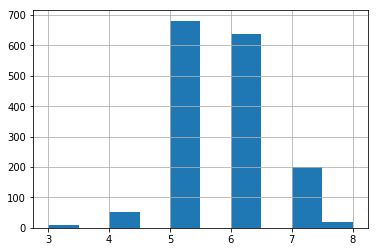

In [52]:
df_red['quality'].hist(bins=10)

In [53]:
df_red['quality'].value_counts() / len(df_red)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [54]:
if binary_target:
    df_red['target'] = df_red['quality'].apply(lambda x: 0 if x < 6 else 1)
else:
    df_red['target'] = df_red['quality']
df_red.drop('quality', axis=1, inplace=True)
target = 'target'
df_red[target].value_counts() / len(df_red)

1    0.534709
0    0.465291
Name: target, dtype: float64

In [55]:
features = [col for col in df_red.columns if col != target]

In [56]:
X_red, y_red = df_red[features].values, df_red[target].values

In [57]:
if scale:
    X_red = scaler.transform(X_red)

In [58]:
y_preds_red  = clf.predict(X_red)

In [59]:
y_preds_red = np.argmax(y_preds_red, axis=1)

In [60]:
accuracy_score(y_preds_red, y_red)

0.5547217010631644

In [61]:
confusion_matrix(y_preds_red, y_red)

array([[720, 688],
       [ 24, 167]])

In [62]:
from sklearn.metrics import precision_score, recall_score

In [63]:
precision_score(y_preds_test, y_test)

0.8468137254901961

In [64]:
precision_score(y_preds_red, y_red)

0.1953216374269006

In [65]:
recall_score(y_preds_test, y_test)

0.8138987043580683

In [66]:
recall_score(y_preds_red, y_red)

0.8743455497382199

### find symmetries

In [67]:
from importlib import reload

In [68]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [69]:
tf.__version__

'1.13.1'

In [70]:
vae = vsf.VaeSymmetryFinder(clf, input_shape=(11,), output_shape=(2, ), intermediate_dim=100)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 11)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          1200        reshape[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            202         dense_2[0][0]                    
__________________________________________________________________________________________________
z_log_

In [71]:
vae.fit(X_train, x_test=X_test, epochs=100)

Train on 3673 samples, validate on 1225 samples
Epoch 1/100
3673/3673 [==============================] - 0s 89us/sample - loss: 0.2173 - val_loss: 0.1803
Epoch 2/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.1838 - val_loss: 0.1795
Epoch 3/100
3673/3673 [==============================] - 0s 11us/sample - loss: 0.1817 - val_loss: 0.1789
Epoch 4/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.1791 - val_loss: 0.1769
Epoch 5/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.1759 - val_loss: 0.1712
Epoch 6/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.1714 - val_loss: 0.1697
Epoch 7/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.1642 - val_loss: 0.1582
Epoch 8/100
3673/3673 [==============================] - 0s 13us/sample - loss: 0.1440 - val_loss: 0.1226
Epoch 9/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.0987 - val_loss: 0.078

3673/3673 [==============================] - 0s 12us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 78/100
3673/3673 [==============================] - 0s 13us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 79/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 80/100
3673/3673 [==============================] - 0s 11us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 81/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 82/100
3673/3673 [==============================] - 0s 11us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 83/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 84/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 85/100
3673/3673 [==============================] - 0s 12us/sample - loss: 0.0015 - val_loss: 0.0018
Epoch 86/100
3673/3673 [==========================

In [72]:
mean_test = []
std_test = []
accs_test = []
for i in range(0, len(X_red), 15):
    rnd_idxs_red  = np.random.choice(range(len(X_red)), i)
    x_cont_red = X_red[rnd_idxs_red]
    y_cont_red = y_red[rnd_idxs_red]
    print('Number of contaminations: {} '.format(i))
    x_test_cont = np.concatenate((X_test, x_cont_red), axis=0)
    y_test_cont = np.concatenate((y_test, y_cont_red), axis=0)
    
    vae_outs_test = vae.vae.predict(x_test_cont)
    symm_samples_test = vae_outs_test[0]
    orig_preds_test = vae_outs_test[1]
    trans_preds_test = vae_outs_test[2]
    
    kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
    mean_test.append(kl_test.mean())
    std_test.append(kl_test.std())
    preds_test = np.argmax(orig_preds_test, axis=1)
    accs_test.append(accuracy_score(preds_test, y_test_cont))


Number of contaminations: 0 
Number of contaminations: 15 
Number of contaminations: 30 
Number of contaminations: 45 
Number of contaminations: 60 
Number of contaminations: 75 
Number of contaminations: 90 
Number of contaminations: 105 
Number of contaminations: 120 
Number of contaminations: 135 
Number of contaminations: 150 
Number of contaminations: 165 
Number of contaminations: 180 
Number of contaminations: 195 
Number of contaminations: 210 
Number of contaminations: 225 
Number of contaminations: 240 
Number of contaminations: 255 
Number of contaminations: 270 
Number of contaminations: 285 
Number of contaminations: 300 
Number of contaminations: 315 
Number of contaminations: 330 
Number of contaminations: 345 
Number of contaminations: 360 
Number of contaminations: 375 
Number of contaminations: 390 
Number of contaminations: 405 
Number of contaminations: 420 
Number of contaminations: 435 
Number of contaminations: 450 
Number of contaminations: 465 
Number of contam

In [73]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f38d84b1e90>,
      dtype=object)

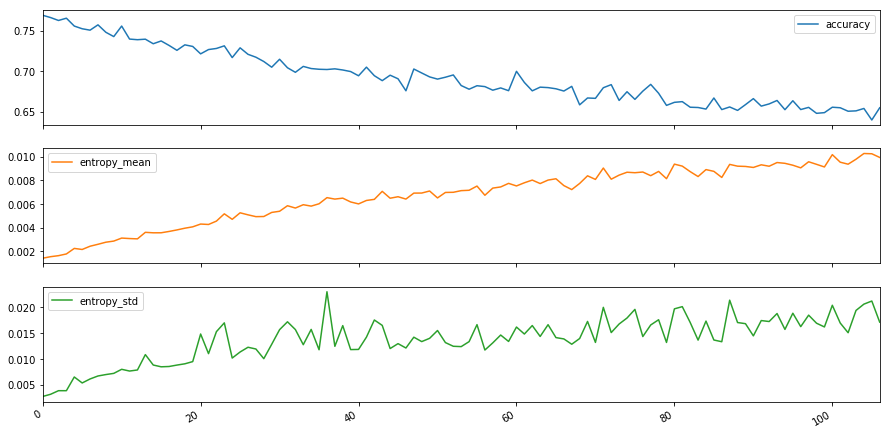

In [74]:
df.plot(logy = False, subplots=True, figsize = (15, 8))

In [75]:
X_test.shape

(1225, 11)

In [76]:
X_red.shape

(1599, 11)

In [77]:
vae_outs_train = vae.vae.predict(X_train)
vae_outs_test = vae.vae.predict(X_red)

symm_samples_train = vae_outs_train[0]
orig_preds_train = vae_outs_train[1]
trans_preds_train = vae_outs_train[2]

symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]

In [78]:
kl_train = entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)

In [79]:
S_train = pd.Series(kl_train, name='train')
S_test = pd.Series(kl_test, name='test')
df_kl = pd.merge(S_train.to_frame(), S_test.to_frame(), right_index=True, left_index=True, how='outer')

0.00133439467754215 0.0029017613269388676
0.016250930726528168 0.02101503126323223


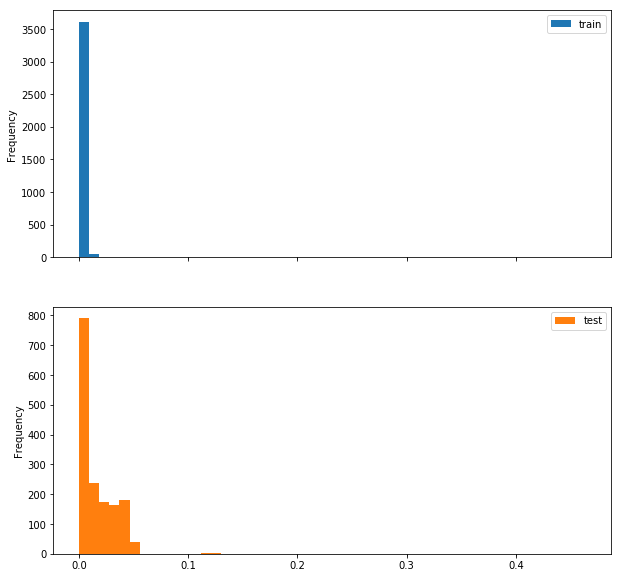

In [80]:
df_kl.plot(kind='hist', bins=50, subplots=True, figsize=(10, 10))
print(S_train.mean(), S_train.std())
print(S_test.mean(), S_test.std())

In [81]:
import matplotlib.pyplot as plt

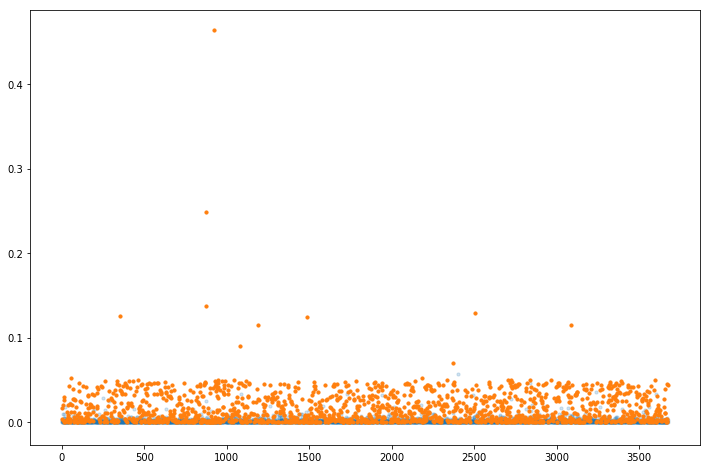

In [82]:
idx_test = np.random.permutation(pd.Series(kl_train).index)[:len(pd.Series(kl_test))]
plt.figure(figsize=(12, 8))
ax1 = plt.scatter(pd.Series(kl_train).index, pd.Series(kl_train), s=10, alpha=0.2)
ax2 = plt.scatter(idx_test, pd.Series(kl_test), s=10, alpha=1)

In [83]:
X_train[0]

array([0.4       , 0.07843137, 0.21686747, 0.03067485, 0.05934718,
       0.09059233, 0.20649652, 0.08000771, 0.35454545, 0.1744186 ,
       0.51612903])

In [84]:
symm_samples_train[0]

array([0.        , 0.03905063, 0.09403051, 0.        , 0.        ,
       0.13047639, 0.06023625, 0.        , 0.10119309, 0.25926673,
       0.22845235], dtype=float32)